# Tutorial 7. Heterogeneous Treatment Effects

by Nadzeya Laurentsyeva @ nadzeya.laurentsyeva@econ.lmu.de



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Introduction 

* We will use with a Python Package for ML-Based Heterogeneous Treatment Effects Estimation 
https://pypi.org/project/econml/
* Start by installing the package 
    
        pip install econml 
        
* Note: to avoid conflicts among different packages, I set-up a virtual environment. You can read more about it virtual_environment.txt 

* Task: partial replication of the Athey and Wager (2018) "Estimating Treatment Effects with Causal Forests: An Application"

Source: https://github.com/grf-labs/grf/tree/master/experiments/acic18 (it contains the code in R).  

# 1. Data and questions to answer 


The dataset is based on real data extracted from the National Study of Learning Mindsets (http://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/). This study evalutes a "nudge-like" intervention to change student behavior at a very low cost and seeks to understand heterogeneity in the intervention. 

The main goal of the study is to test for heterogeneity in the effect of an intervention designed to instill students with a "growth mindset": the belief that intelligence can be developed. 

The simulated data contain similar characteristics as the National Study (including covariate distributions, data structures, and effect sizes). 

The dataset comprises about 10,000 students in 76 schools with an outcome Y (a continuous measure of achievement), a binary treatment variable Z indicating receipt of the intervention, and the following 10 covariates at both the student and school level:

* S3 - Students' self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment
*  C1 - Categorical variable for student race/ethnicity
*   C2 - Categorical variable for student identified gender
*  C3 - Categorical variable for student first-generation status (i.e. first in family to go to college)
*  XC - School-level categorical variable for urbanicity of the school (i.e. rural, suburban, etc.)
*  X1 - School-level mean of students' fixed mindsets, reported prior to random assignment
* X2 - School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students
* X3 - School racial/ethnic minority composition -- i.e. % black, latino, or native/american
* X4 - School poverty concentration -- i.e. % of students who are from families whose incomes fall below the federal poverty line
* X5 - School size - Total # of students in all four grade levels in the school

The main questions: 

  1. Was the mindset intervention effective in improving student achievement?
  2. Researchers hypothesize that the effect of the intervention is moderated by school level achievement (X2) and pre-existing mindset norms (X1). 

In [2]:
# Packages to import 
from econml.dml import ForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

In [3]:
# Data 
cols = ['schoolid', 'treat', 'y', 'prior_achieve', 'race', 'gender', 'first-generation', \
       'location', 'fixed_mind', 'school_achieve', 'school_race', 'school_poverty', 'school_size']
df = pd.read_csv('data lecture 5/synthetic_data.csv')
df.columns=cols
df.describe()

,schoolid,treat,y,prior_achieve,race,gender,first-generation,location,fixed_mind,school_achieve,school_race,school_poverty,school_size
count,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000
mean,39.888846,0.325666,-0.096742,5.268117,5.223078,1.489943,0.630931,2.447791,-0.040457,0.054841,-0.089349,-0.045911,-0.026168
std,24.008975,0.468646,0.643009,1.120765,3.982963,0.499923,0.482576,1.378420,0.969743,0.935560,0.962804,0.967262,1.010387
min,1.000000,0.000000,-2.097420,1.000000,1.000000,1.000000,0.000000,0.000000,-3.088790,-3.347819,-1.575463,-1.924778,-1.805073
25%,19.000000,0.000000,-0.548980,5.000000,3.000000,1.000000,0.000000,1.000000,-0.617888,-0.544506,-0.963095,-0.813799,-0.857026
50%,41.000000,0.000000,-0.118923,5.000000,4.000000,1.000000,1.000000,2.000000,-0.009954,-0.022514,-0.057036,-0.159602,-0.211553
75%,62.000000,1.000000,0.335663,6.000000,5.000000,2.000000,1.000000,4.000000,0.420441,0.726836,0.515392,0.596474,0.847844
max,76.000000,1.000000,2.194709,7.000000,15.000000,2.000000,1.000000,4.000000,2.834589,2.171815,2.358274,2.821660,1.892348


<div class="alert alert-block alert-info">
<b>Question 1:</b> 
    
* We have three categorical variables. Should we or should we not include dummies for them? How can we check?  
  
* Is it a problem that students from larger schools are more likely to be in our sample? If yes, how can we correct for this? 
    
</div>

In [5]:
# we can fit random forest with and without dummies and compare the model's performance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import tree as tree

In [6]:
# count how many observations we have per school, will be used to calculate sample weights
# if we don't use sample weights, then our trees will be biased toward dominant classes (schools of a larger size)
df.groupby(['schoolid'], as_index=False)['y'].agg({"n_obs": "count"})

,schoolid,n_obs
0,1,72
1,2,321
2,3,201
3,4,292
4,5,189
...,...,...
71,72,233
72,73,270
73,74,258
74,75,163


In [7]:
# merge it to the dataset 
df = pd.merge(df, df.groupby(['schoolid'], as_index=False)['y'].agg({"n_obs": "count"}), on = ['schoolid'])
df.head()

,schoolid,treat,y,prior_achieve,race,gender,first-generation,location,fixed_mind,school_achieve,school_race,school_poverty,school_size,n_obs
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,196
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,196
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,196
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,196
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,196


In [8]:
df[['treat', 'prior_achieve', 'first-generation', 'fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race']].join(df[['gender', 'location', 'race']]).join(df['n_obs'])

,treat,prior_achieve,first-generation,fixed_mind,school_achieve,school_poverty,school_size,school_race,gender,location,race,n_obs
0,1,6,1,0.334544,0.648586,0.224077,-0.426757,-1.310927,2,4,4,196
1,1,4,1,0.334544,0.648586,0.224077,-0.426757,-1.310927,2,4,12,196
2,1,6,0,0.334544,0.648586,0.224077,-0.426757,-1.310927,2,4,4,196
3,1,6,0,0.334544,0.648586,0.224077,-0.426757,-1.310927,2,4,4,196
4,1,6,0,0.334544,0.648586,0.224077,-0.426757,-1.310927,1,4,4,196
...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0,7,1,1.185986,-1.129889,1.005063,-1.174702,1.009875,2,3,4,72
10387,0,7,1,1.185986,-1.129889,1.005063,-1.174702,1.009875,2,3,4,72
10388,0,2,1,1.185986,-1.129889,1.005063,-1.174702,1.009875,1,3,15,72
10389,0,5,1,1.185986,-1.129889,1.005063,-1.174702,1.009875,1,3,4,72


In [13]:
# no dummies, no weights
y = df['y'] 
X = df[['treat', 'prior_achieve', 'first-generation', 'fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race']].join(df[['gender', 'location', 'race']]).join(df['n_obs'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

# Note that we need to set the stopping rule here
# One solution could be to iterate over the min_samples_leaf and select the best model using CV
rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 25, min_weight_fraction_leaf = 0, \
                                    oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train.iloc[:, : -1], y_train)

y_pred = rf.predict(X_test.iloc[:, : -1])
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Out-of-sample Rsq: 0.339
Out-of-sample MSE: 0.269


In [14]:
# no dummies, with weights
y = df['y'] 
X = df[['treat', 'prior_achieve', 'first-generation', 'fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race']].join(df[['gender', 'location', 'race']]).join(df['n_obs'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

# Note the application of sample_weights: https://scikit-learn.org/stable/modules/tree.html#regression
# If the samples are weighted, it will be easier to optimize the tree structure using weight-based pre-pruning criterion such as min_weight_fraction_leaf, which ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights.
rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, min_weight_fraction_leaf = 0.004, \
                                    oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train.iloc[:, : -1], y_train, sample_weight = 1/X_train['n_obs'])

y_pred = rf.predict(X_test.iloc[:, : -1])
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred, sample_weight = 1/X_test['n_obs']))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred, sample_weight = 1/X_test['n_obs']))

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Out-of-sample Rsq: 0.346
Out-of-sample MSE: 0.282


In [15]:
# create dummies for categorical variables: prior_achieve, race, gender
# note, you can do the same with OneHotEncoder from sklearn https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# also note, that it is not necessary to set drop_first = True 
dummies = [pd.get_dummies(df[i], prefix=i, drop_first = True) for i in ['location', 'race', 'gender']]

In [16]:
# with dummies
y = df['y'] 
X = df[['treat', 'prior_achieve', 'first-generation', 'fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race']].join(dummies).join(df['n_obs'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, min_weight_fraction_leaf = 0.004, \
                                    oob_score = True,    random_state = 1)
rf = rf.fit(X_train.iloc[:, : -1], y_train, sample_weight = 1/X_train['n_obs'])

y_pred = rf.predict(X_test.iloc[:, : -1])
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred, sample_weight = 1/X_test['n_obs']))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred, sample_weight = 1/X_test['n_obs']))

# in our case, it does not matter that much. Why do you think this is the case? 

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Out-of-sample Rsq: 0.347
Out-of-sample MSE: 0.281


<div class="alert alert-block alert-info">
<b>Question 2:</b> 
    
* Can we consider the treatment as randomly assigned? How can we check? 
    
* What can we do if it is not? 
    
</div>


In [17]:
import statsmodels.api as sm
y = df['treat'] 
X = df[['prior_achieve', 'first-generation', 'fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race']].join(dummies)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df['schoolid']})
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  treat   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     10.67
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           4.09e-16
Time:                        11:26:58   Log-Likelihood:                -6822.5
No. Observations:               10391   AIC:                         1.370e+04
Df Residuals:                   10364   BIC:                         1.389e+04
Df Model:                          26                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2117      0.027      7.810      0.000       0.159       0.265
prior_achieve        0.0215      0.004      5.250      0.000       0.013       0.030
first-generation    -0.0286      0.009     -3.044      0.002      -0.047      -0.010
fixed_mind          -0.0181      0.004     -5.141      0.000      -0.025      -0.011
school_achieve      -0.0018      0.005     -0.390      0.697      -0.011       0.007
school_poverty      -0.0029      0.004     -0.819      0.413      -0.010       0.004
school_size          0.0001      0.004      0.028      0.978      -0.008       0.008
school_race          0.0085      0.005      1.821      0.069      -0.001       0.018
location_1          -0.0058      0.011     -0.552      0.581      -0.027       0.015
location_2           0.0162      0.013      1.254      0.210      -0.009       0.041
location_3          -0.0006      0.011     -0.053      0.958      -0.022       0.021
location_4           0.0178      0.009      2.055      0.040       0.001       0.035
race_2               0.0225      0.017      1.348      0.178      -0.010       0.055
race_3               0.0097      0.053      0.185      0.854      -0.093       0.113
race_4               0.0279      0.017      1.627      0.104      -0.006       0.062
race_5               0.0224      0.030      0.754      0.451      -0.036       0.081
race_6               0.1329      0.085      1.555      0.120      -0.035       0.300
race_7               0.0750      0.083      0.903      0.367      -0.088       0.238
race_8               0.0659      0.036      1.832      0.067      -0.005       0.136
race_9              -0.0345      0.048     -0.718      0.473      -0.129       0.060
race_10              0.0381      0.041      0.939      0.348      -0.041       0.118
race_11              0.0119      0.032      0.376      0.707      -0.050       0.074
race_12              0.0170      0.029      0.588      0.557      -0.040       0.074
race_13             -0.0507      0.035     -1.459      0.145      -0.119       0.017
race_14              0.0106      0.024      0.442      0.659      -0.036       0.058
race_15              0.0357      0.028      1.291      0.197      -0.019       0.090
gender_2            -0.0226      0.008     -2.806      0.005      -0.038      -0.007
==============================================================================
Omnibus:                    86134.952   Durbin-Watson:                   0.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1808.167
Skew:                           0.734   Prob(JB):                         0.00
Kurtosis:                       1.578   Cond. No.                         98.3
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlati

# 2. Estimation

We estimate the effects conditional on covariates $X$.

\begin{equation}
\{ Y_i(0), Y_i(1) \} \  \bot \   T_i | X_i 
\end{equation}

Practically, we start by fitting two separate regressions to map $X$ to $Y$ (outcomes) and to $T$ (treatment). 

Note: we can choose different models for that. 

Which tools should we select? 

https://econml.azurewebsites.net/spec/flowchart.html

In [22]:
# https://econml.azurewebsites.net/_autosummary/econml.dml.html#econml.dml.ForestDML

from econml.dml import ForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore') # warnings will be ignored

y = df['y'] 
X = df[['fixed_mind', 'school_achieve', 'school_poverty', 'gender', 'first-generation']] # X - features, we are explicitly interested in their heterogeneous impact
W = df[['prior_achieve', 'school_race', 'location', 'race', 'school_size']]
# W - if we have imperfect compliance or too many controls (and want to choose the relevant ones, \
# we can also add confounders W. (comes from double orthogonalization ideas, see Lecture 1)
# Note that Athey and Wager use all their covariates as X. In this case, W is either omitted or set to W=None
T = df['treat']
 
# here we define the models for y and t (we can choose also simple Linear Regressions, Lasso, etc..)
fit_y = RandomForestRegressor(n_estimators=100, min_weight_fraction_leaf = 0.004, oob_score = True,   random_state=1)
fit_t = RandomForestClassifier(n_estimators=100, min_weight_fraction_leaf = 0.004, oob_score = True,   random_state=1)
# Note, it is also possible to tune the parameters for all the fitted regressions, as well as to select a model that fits the best
# Check the implementation here: https://github.com/microsoft/EconML/blob/master/notebooks/ForestLearners%20Basic%20Example.ipynb

est = ForestDML(model_y= fit_y, 
                model_t=fit_t,
                discrete_treatment=True,
                n_estimators=100,
                honest = True, # default
                subsample_fr='auto',
                min_samples_leaf=25,
                verbose = 0,
                min_weight_fraction_leaf=.004, 
                random_state = 1)
est.fit(y, T, X=X, W=W, sample_weight = 1/df['n_obs'], inference = 'blb') # bootstrap’ (or an instance of BootstrapInference) or ‘blb’ (for Bootstrap-of-Little-Bags based inference)

In [23]:
# which features seem to be important 
from econml.cate_interpreter import SingleTreeCateInterpreter
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=25)
intrp.interpret(est, X)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

In [24]:
# Feature importance
imp = pd.DataFrame(est.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)

# up to you to try out other dimensions 

,Feature importance,Feature
0,0.382835,fixed_mind
1,0.293118,school_achieve
2,0.202579,school_poverty
3,0.075745,gender
4,0.045723,first-generation


In [25]:
# we get estimated treatment effects with 90% confidence intervals 
te_pred = est.effect(X)
te_pred_interval = est.effect_interval(X)
res = est.effect_inference(X)
# you can also use est.effect_inference(X) to obtain full information (point estimate, se, pvalue, bounds)
# about estimated treatment effects 

In [26]:
# summary of the estimated treatment effects
res.population_summary()

In [33]:
# can compare with the ATE from a linear model
y = df['y'] 
X = df[['treat', 'prior_achieve', 'first-generation', 'fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race']].join(dummies)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df['schoolid']})
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     228.0
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           1.89e-61
Time:                        11:06:07   Log-Likelihood:                -8265.5
No. Observations:               10391   AIC:                         1.659e+04
Df Residuals:                   10363   BIC:                         1.679e+04
Df Model:                          27                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2217      0.082    -14.920      0.000      -1.382      -1.061
treat                0.2531      0.017     14.958      0.000       0.220       0.286
prior_achieve        0.2417      0.006     42.663      0.000       0.231       0.253
first-generation    -0.0939      0.011     -8.322      0.000      -0.116      -0.072
fixed_mind          -0.0826      0.028     -2.934      0.003      -0.138      -0.027
school_achieve      -0.0235      0.029     -0.802      0.423      -0.081       0.034
school_poverty      -0.0029      0.026     -0.111      0.912      -0.054       0.049
school_size         -0.0454      0.024     -1.882      0.060      -0.093       0.002
school_race          0.0302      0.021      1.437      0.151      -0.011       0.071
location_1          -0.1908      0.080     -2.371      0.018      -0.348      -0.033
location_2          -0.0124      0.081     -0.152      0.879      -0.172       0.147
location_3          -0.1289      0.087     -1.476      0.140      -0.300       0.042
location_4           0.0340      0.081      0.422      0.673      -0.124       0.192
race_2               0.0192      0.032      0.598      0.550      -0.044       0.082
race_3              -0.1147      0.056     -2.054      0.040      -0.224      -0.005
race_4              -0.0899      0.027     -3.286      0.001      -0.144      -0.036
race_5               0.2317      0.041      5.662      0.000       0.151       0.312
race_6              -0.0897      0.070     -1.275      0.202      -0.228       0.048
race_7              -0.1188      0.087     -1.367      0.172      -0.289       0.052
race_8              -0.0473      0.046     -1.027      0.304      -0.137       0.043
race_9              -0.1369      0.051     -2.669      0.008      -0.237      -0.036
race_10             -0.1462      0.052     -2.811      0.005      -0.248      -0.044
race_11             -0.0878      0.050     -1.740      0.082      -0.187       0.011
race_12              0.1035      0.042      2.439      0.015       0.020       0.187
race_13             -0.1525      0.045     -3.421      0.001      -0.240      -0.065
race_14              0.0279      0.034      0.818      0.413      -0.039       0.095
race_15              0.0637      0.042      1.534      0.125      -0.018       0.145
gender_2            -0.1694      0.010    -16.598      0.000      -0.189      -0.149
==============================================================================
Omnibus:                       54.094   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.117
Skew:                           0.105   Prob(JB):                     9.68e-11
Kurtosis:                       2.751   Cond. No.                         98.5
=====================================================

In [36]:
# merge with our data (not a necessary step if we don't want to work further with schoolid)
out = df.copy()
out['te_pred'] = te_pred
out = out.join(pd.DataFrame(data = np.transpose(te_pred_interval), columns=['lb', 'ub']))
out['te_pred'].hist()
%matplotlib inline

<AxesSubplot:xlabel='fixed_mind', ylabel='school_poverty'>

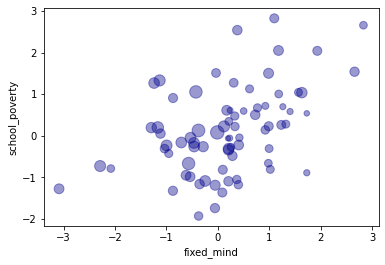

In [38]:
c = out.groupby(['school_poverty', 'fixed_mind'], as_index=False)['te_pred'].mean()
c.plot.scatter(y = 'school_poverty', x = 'fixed_mind', s = 400*c['te_pred'], c='DarkBlue', alpha = 0.4)

<AxesSubplot:xlabel='school_poverty', ylabel='te_pred'>

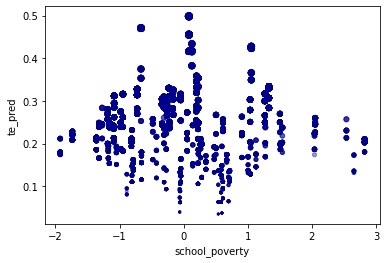

In [37]:
out.plot.scatter(y = 'te_pred', x = 'school_poverty', s = 100*out['te_pred'], c='DarkBlue', alpha = 0.4)

In [31]:
# test 

y = df['y'] 
X = df[['schoolid', 'treat', 'prior_achieve', 'first-generation', 'fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race', 'gender', 'location', 'race']].join(df['n_obs'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 


fit_y = RandomForestRegressor(n_estimators=100, min_samples_leaf = 25, min_weight_fraction_leaf = 0.004, oob_score = True,   random_state=1)
fit_t = RandomForestClassifier(n_estimators=100, min_samples_leaf = 25, min_weight_fraction_leaf = 0.004, oob_score = True,   random_state=1)

y_pred = fit_y.fit(X_train.iloc[:, 2:-1], y_train, sample_weight = 1/X_train['n_obs']).predict(X_test.iloc[:, 2:-1])
t_pred = fit_t.fit(X_train.iloc[:, 2:-1], X_train['treat'], sample_weight = 1/X_train['n_obs']).predict(X_test.iloc[:, 2:-1])

est = ForestDML(model_y= fit_y, 
                model_t=fit_t,
                discrete_treatment=True,
                n_crossfit_splits=3, 
                n_estimators=100,
                honest = True, # default
                subsample_fr='auto',
                min_samples_leaf=25,
                verbose = 0,
                min_weight_fraction_leaf=.004, 
                random_state = 1)
est.fit(y_train, X_train['treat'], X=X_train.iloc[:, 2:-1], W=None, \
        sample_weight = 1/X_train['n_obs'], inference = 'blb') # bootstrap’ (or an instance of BootstrapInference) or ‘blb’ (for Bootstrap-of-Little-Bags based inference)

In [32]:
te_pred = est.effect(X_test.iloc[:, 2:-1])
te_pred_interval = est.effect_interval(X_test.iloc[:, 2:-1])
res = est.effect_inference(X_test.iloc[:, 2:-1])

In [33]:
res.population_summary()

In [34]:
X_test['mean_pred']=te_pred.mean()*(X_test['treat']-t_pred)
X_test['diff_pred']=(te_pred - te_pred.mean())*(X_test['treat']-t_pred)
Y = y_test-y_pred
X_test

,schoolid,treat,prior_achieve,first-generation,fixed_mind,school_achieve,school_poverty,school_size,school_race,gender,location,race,n_obs,mean_pred,diff_pred
6890,25,1,6,1,-0.245587,1.332074,-1.083400,0.325777,-1.101778,1,2,4,341,0.268594,0.055638
5692,34,1,6,1,-0.873061,0.900255,-1.319060,-0.857026,-0.789685,1,2,4,172,0.268594,0.014121
7824,18,1,6,1,1.636430,-0.065161,1.037373,-0.375073,0.694201,2,4,1,178,0.268594,-0.014297
8229,16,0,5,0,-0.538975,1.433826,-0.982274,1.591641,-0.033161,2,1,4,226,0.000000,-0.000000
3733,57,1,6,0,0.097162,-0.292353,-0.813799,0.184716,-1.030865,1,2,4,211,0.268594,0.001457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7030,25,0,2,0,-0.245587,1.332074,-1.083400,0.325777,-1.101778,2,2,4,341,0.000000,-0.000000
1098,72,0,4,1,0.420441,-0.491972,-0.043159,-0.438531,-0.913405,1,3,4,233,0.000000,-0.000000
7951,18,0,6,1,1.636430,-0.065161,1.037373,-0.375073,0.694201,2,4,4,178,0.000000,0.000000
7987,17,1,7,1,1.570640,-1.021504,1.043998,-0.470404,0.361202,2,4,4,128,0.268594,0.020017


In [35]:
# regress y-residuals on average and heterogeneous treatment 
# test for heterogeneity, motivated by Chernozhukov et al. (2018)
# seeks to fit the CATE as a linear function of the the out-of-bag causal forest estimates
X = X_test[['mean_pred', 'diff_pred']]
X = sm.add_constant(X)
est = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': X_test['schoolid']})
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     46.19
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           8.42e-14
Time:                        11:22:23   Log-Likelihood:                -1575.0
No. Observations:                2079   AIC:                             3156.
Df Residuals:                    2076   BIC:                             3173.
Df Model:                           2                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0783      0.017     -4.673      0.000      -0.111      -0.045
mean_pred      0.8453      0.090      9.407      0.000       0.669       1.021
diff_pred      0.5595      0.635      0.882      0.378      -0.684       1.803
==============================================================================
Omnibus:                        8.453   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.339
Skew:                           0.083   Prob(JB):                       0.0255
Kurtosis:                       2.762   Cond. No.                         45.3
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [470]:
X = X_test[['fixed_mind', 'school_achieve', \
       'school_poverty', 'school_size', 'school_race']]
X = sm.add_constant(X)
est = sm.OLS(te_pred, X).fit(cov_type='cluster', cov_kwds={'groups': X_test['schoolid']})
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     12.70
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           6.05e-09
Time:                        01:41:47   Log-Likelihood:                 4310.8
No. Observations:                2079   AIC:                            -8610.
Df Residuals:                    2073   BIC:                            -8576.
Df Model:                           5                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2673      0.003     98.784      0.000       0.262       0.273
fixed_mind        -0.0144      0.003     -4.413      0.000      -0.021      -0.008
school_achieve     0.0128      0.005      2.394      0.017       0.002       0.023
school_poverty     0.0023      0.002      1.045      0.296      -0.002       0.007
school_size       -0.0062      0.003     -1.993      0.046      -0.012      -0.000
school_race       -0.0004      0.004     -0.109      0.913      -0.007       0.007
==============================================================================
Omnibus:                       10.926   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.970
Skew:                           0.177   Prob(JB):                      0.00415
Kurtosis:                       3.026   Cond. No.                         2.90
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

# Resources 

* Useful example of different Forest Learners implemented in Econ ML https://github.com/microsoft/EconML/blob/master/notebooks/ForestLearners%20Basic%20Example.ipynb 

* 1. Case illustration with EconML https://github.com/microsoft/EconML/blob/master/notebooks/CustomerScenarios/Case%20Study%20-%20Customer%20Segmentation%20at%20An%20Online%20Media%20Company.ipynb 

* 2. Case illustration with EconML https://github.com/microsoft/EconML/blob/master/notebooks/Causal%20Forest%20and%20Orthogonal%20Random%20Forest%20Examples.ipynb


* For R-users: Replication files for the paper "Estimating Treatment Effects with Causal Forests: An Application", by Athey and Wager https://github.com/grf-labs/grf/tree/master/experiments/acic18